# Ensemble Testing
This Notebook is used to test the performance of a GNN ensemble.
The training of ```n_reps``` models is done in ```ensemble_train.py``` and can be configured using ```ensemble_config.yaml```.

In [1]:
import subprocess
from multiprocessing import Process

from ensemble_train import crps, create_model_from_config, crps_no_avg
import numpy as np
import pandas as pd
import os
import sys
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import summary
from tqdm import tqdm
import yaml
import cmasher as cmr

sys.path.append('../utils')
import helpers

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size': 16})


from scipy.stats import norm
%matplotlib inline

In [2]:
ensemble_config = "experiments/large/best_GlobalInfo/config.yaml"

with open(ensemble_config, 'r') as config_file:
    config = yaml.safe_load(config_file)

save_path = os.path.dirname(ensemble_config)
name = "_".join(save_path.split("/")[-1:-3:-1])

## Train an Ensemble based on the config

In [9]:
def split_list(input_list, n):
    return [input_list[i:i + n] for i in range(0, len(input_list), n)]

def run_script(params):
    """
    Train a single model by launching a single subprocess facilitating the training
    :param params: tuple containing the id of the run, the device number and the name of the config file for the run
    """
    if "small" in params[2]:
        small = True
    else:
        small = False

    id_val, device_val, config_val = params
    cmd = [sys.executable, "ensemble_train.py", "--id", str(id_val), "--device", str(device_val), "--config", config_val, "--small" if small else "--no-small"]
    subprocess.run(cmd)

def train_ensemble(config_path, n):
    """
    Trains an ensemble of models
    :param config_path: path to the config file of the models
    :param n: number of models to train in parallel
    """
    params = [(i, i%2, config_path) for i in range(10)]
    params_list_list = split_list(params, n)

    for params_list in params_list_list:
        print(f"Start training of models")
        processes = []
        for params in params_list:
            print(params[0])
            process = Process(target=run_script, args=(params,))
            processes.append(process)
            process.start()

        for process in processes:
            process.join()

In [10]:
%%time
train_ensemble(ensemble_config, 10)

Start training of models
0
1
2
3
4
5
6
7
8
9
Model 8 start
Model 8 trained in: 21min 39s 
Model 4 start
Model 4 trained in: 21min 40s 
Model 6 start
Model 6 trained in: 21min 40s 
Model 2 start
Model 2 trained in: 21min 41s 
Model 0 start
Model 0 trained in: 21min 41s 
Model 3 start
Model 3 trained in: 22min 29s 
Model 5 start
Model 5 trained in: 22min 29s 
Model 7 start
Model 7 trained in: 22min 29s 
Model 1 start
Model 1 trained in: 22min 30s 
Model 9 start
Model 9 trained in: 22min 30s 
CPU times: user 395 ms, sys: 441 ms, total: 836 ms
Wall time: 22min 33s


# Evaluation

In [15]:
# Get Data from feather
print("Loading Data ...")
data = helpers.load_data(indexed=False)

if not os.path.exists("dist_matrix.npy"):
    print("Creating distance matrix ...")
    stations = helpers.load_stations(data)  # This needs to be done here because we need all stations
    dist_matrix = helpers.compute_dist_matrix(stations)
    np.save('dist_matrix.npy', dist_matrix)

# Clean Data
print("Cleaning Data ...")
data = helpers.clean_data(data, max_missing=121, max_alt=1000.0)

# Cut Dataset to only 2015 and 2016 (2016 wont be used anyway)
if "small" in name:
    data = data[data.date.dt.year >= 2015]

# Normalize Data
print("Normalizing Data ...")
normalized_data = helpers.normalize_data(data, last_obs=-len(data[data.date.dt.year == 2016]), method="max") #last_obs is -365 since the last year is used for testing

# Get List of stations with all stations -> will break further code if cut already
print("Extracting Stations ...")
stations = helpers.load_stations(data)


dist_matrix = np.load('dist_matrix.npy')
corr_matrix = np.load('corr_matrix.npy')
position_matrix = np.array(stations[['station', 'lon', 'lat']])


torch_data_test = []
for date in tqdm(data['date'].unique()[-366:], desc="Creating PyG Data"):
    torch_data_test.append(helpers.create_data(df=normalized_data,
                                               date=date,
                                               dist_matrix=dist_matrix if not config['data']['use_corr'] else corr_matrix,
                                               position_matrix=position_matrix,
                                               method=config['data']['method'],
                                               max_dist=config['data']['max_dist'],
                                               k=config['data']['nearest_k'],
                                               nearest_k_mode=config['data']['nearest_k_mode']))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move all the data directly to the GPU (should fit into memory)
# torch_data_train only contains training datat 2007-2015
torch_data_test = [tensor.to(device) for tensor in torch_data_test]

# Definition of train_loader and valid_loader
test_loader = DataLoader(torch_data_test, batch_size=8, shuffle=False)

Loading Data ...
Cleaning Data ...
Normalizing Data ...
Extracting Stations ...


Creating PyG Data: 100%|██████████| 366/366 [00:05<00:00, 71.37it/s]


In [23]:
def get_models_from_checkpoints():
    emb_num_features = torch_data_test[0].num_features + config['model']['embed_dim'] - 1

    model_list = []
    for snapshot in os.listdir(f"{os.path.dirname(ensemble_config)}/checkpoints"):
        path_to_snapshot = f"{os.path.dirname(ensemble_config)}/checkpoints/{snapshot}"
        model, optimizer, _ = create_model_from_config(config, emb_num_features, device)
        try:
            checkpoint = torch.load(path_to_snapshot)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model_list.append(model)
            print(f"Loaded {path_to_snapshot}")
        except Exception as e:
            print(e)
            print(f"could not load {path_to_snapshot}")
    return model_list

def evaluate_ensemble(model_list:list):
    mu_list_model = []
    sigma_list_model = []

    for model in model_list:
        mu_list_batch = []
        sigma_list_batch = []
        y_list = []
        ids_list = []

        for batch in test_loader:
            ids = batch.x[:, 0]
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            mu, sigma = torch.split(out, 1, dim=-1)
            y = batch.y
            y = y.cpu().numpy()
            y_list.append(y)
            ids = ids.cpu().numpy().flatten()
            ids_list.append(ids)

            mu = mu.detach().cpu().numpy().flatten()
            mu_list_batch.append(mu)
            sigma = sigma.detach().cpu().numpy().flatten()
            sigma_list_batch.append(sigma)


        mu = np.concatenate(mu_list_batch)
        mu_list_model.append(mu)
        sigma = np.concatenate(sigma_list_batch)
        sigma_list_model.append(sigma)
        y = np.concatenate(y_list)
        ids = np.concatenate(ids_list)
        print(f"Model CRPS {crps(torch.cat([torch.tensor(mu).view(-1,1), torch.tensor(sigma).view(-1,1)], dim=1), torch.tensor(y))}")
    mu = np.array(mu_list_model).T.mean(axis=1).reshape(-1,1)
    sigma = np.array(sigma_list_model).T.mean(axis=1).reshape(-1,1)
    ids = np.array(ids).T.flatten()

    mu = torch.tensor(mu).to(device)
    sigma = torch.tensor(sigma).to(device)
    preds = torch.cat([mu, sigma], dim=1)
    y = torch.tensor(y).to(device)
    err = crps(mu_sigma=preds, y=y)
    crps_station = crps_no_avg(mu_sigma=preds, y=y)

    y = y.detach().cpu().numpy()
    mu = mu.detach().cpu().numpy()
    sigma = sigma.detach().cpu().numpy()
    return err, mu, sigma, y, ids, preds, crps_station

In [24]:
ensemble = get_models_from_checkpoints()
err, mu, sigma, y, ids, preds, crps_station= evaluate_ensemble(ensemble)
ids = ids.astype(int)
print(f"Ensemble CRPS8 {err}")

Loaded experiments/large/best_GlobalInfo/checkpoints/model_7.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_2.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_5.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_1.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_8.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_4.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_3.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_6.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_0.pt
Loaded experiments/large/best_GlobalInfo/checkpoints/model_9.pt
Model CRPS 0.7778786420822144
Model CRPS 0.8016789555549622
Model CRPS 0.8069403767585754
Model CRPS 0.7910984754562378
Model CRPS 0.7750085592269897
Model CRPS 0.7821601033210754
Model CRPS 0.8091862201690674
Model CRPS 0.876698911190033
Model CRPS 0.7853450179100037
Model CRPS 0.7775688171386719
Ensemble CRPS8 0.7562628984451294


In [6]:
# Model sumary
tmp = torch_data_test[0]
print(summary(ensemble[0],
              x=tmp.x.to(device),
              edge_index=tmp.edge_index.to(device),
              edge_attr=tmp.edge_attr.to(device),
              batch_id=torch.zeros(tmp.x.shape[0]).to(torch.int64).to(device)))

+----------------------------+--------------------------------------------------+---------------------+----------+
| Layer                      | Input Shape                                      | Output Shape        | #Param   |
|----------------------------+--------------------------------------------------+---------------------+----------|
| GNNGI                      |                                                  | [468, 2]            | 240,508  |
| ├─(emb)EmbedStations       | [468, 42]                                        | [468, 51]           | 5,350    |
| │    └─(embed)Embedding    | [468]                                            | [468, 10]           | 5,350    |
| ├─(convolutions)ModuleList | --                                               | --                  | 234,900  |
| │    └─(0)MPWGI            | [468, 51], [2, 4680], [4680, 1], [1, 51], [468]  | [468, 128], [1, 51] | 58,588   |
| │    └─(1)MPWGI            | [468, 128], [2, 4680], [4680, 1], [1, 51], [468] 

# Plot
## CRPS vs. Temp

In [31]:
crps_per_obs = crps_no_avg(preds.cpu(), torch.tensor(y)).flatten().numpy()
# Assuming you have the numpy arrays crps_per_obs and y
# Create bins for y values from -10 to 20 with a step of 0.5
y_bins = np.arange(-20, y.max()+0.5, 0.5)

# Use digitize to assign each y value to its corresponding bin
y_bin_indices = np.digitize(y, y_bins)

# Initialize an array to store the average crps_per_obs for each bin
average_crps = np.zeros(len(y_bins) - 1)

# Calculate the average crps_per_obs for each bin
for i in range(1, len(y_bins)):
    mask = (y_bin_indices == i)
    if np.any(mask):
        average_crps[i - 1] = np.mean(crps_per_obs[mask])

# Save for multiline plot
df = pd.read_csv('experiments/meanCRPSVsTemp.csv')
df[f"Average_CRPS_{name}"] = average_crps
df.to_csv('experiments/meanCRPSVsTemp.csv', index=False)

## Sigma vs. Temp

In [32]:
# Initialize an array to store the average crps_per_obs for each bin
average_sigma = np.zeros(len(y_bins) - 1)

# Calculate the average crps_per_obs for each bin
for i in range(1, len(y_bins)):
    mask = (y_bin_indices == i)
    if np.any(mask):
        average_sigma[i - 1] = np.mean(sigma[mask])

# Save for multiline plot
df = pd.read_csv('experiments/meanSigmaVsTemp.csv')
df[f"Average_SD_{name}"] =  average_sigma
df.to_csv('experiments/meanSigmaVsTemp.csv', index=False)

## Heatmap of Observations (Absolute error vs predicted Sigma)

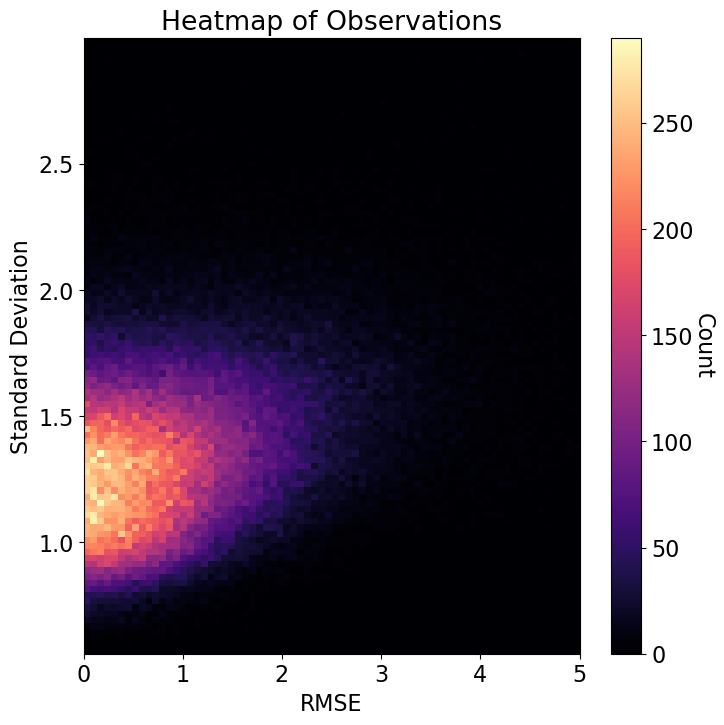

In [64]:
plt.figure(figsize=(8,8))

# Omit standard deviatons > 3 to make the plot better (plt.ylim has some errors)
mask = sigma.flatten() <= 3 # insignificant amount of data in this area
abs_error = np.abs(mu.flatten()-y)[mask]
sigma_cut = sigma.flatten()[mask]


plt.hist2d(abs_error, sigma_cut, bins=(300, 100), cmap='magma', rasterized=True)
plt.xlim(0, 5)
cbar = plt.colorbar()
cbar.set_label('Count', rotation=270, labelpad=15)
plt.xlabel('RMSE')
plt.ylabel('Standard Deviation')
plt.title('Heatmap of Observations')
plt.savefig(f"{save_path}/Heatmap_{name}.pdf", format='pdf', dpi=600, bbox_inches='tight')

## Observed vs. Actual value

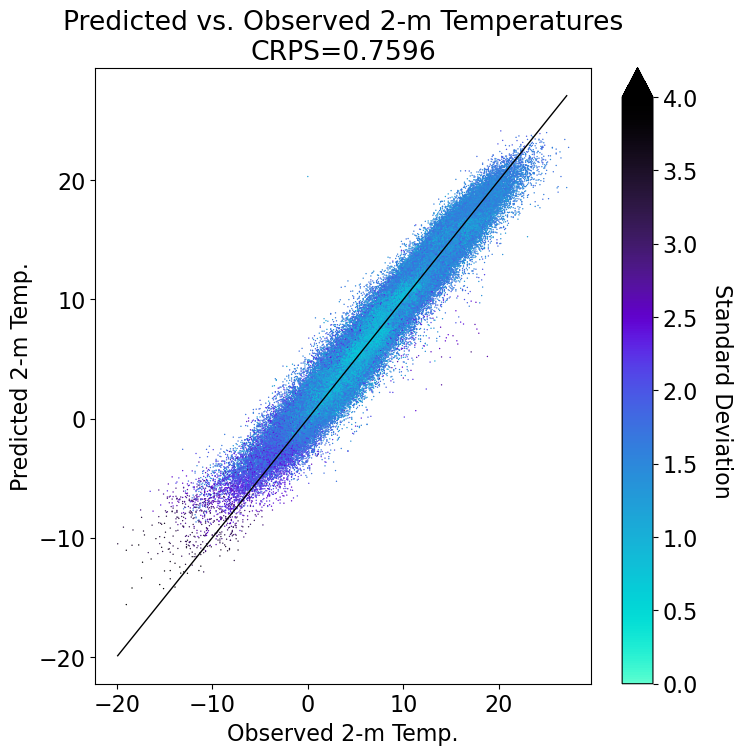

In [56]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")  # line
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap=cmr.get_sub_cmap(cmr.cosmic_r,0.0,1), vmin=0, vmax=4, rasterized=True)

cbar = plt.colorbar(extend='max')
cbar.set_label('Standard Deviation', rotation=270, labelpad=25)
plt.xlabel('Observed 2-m Temp.')
plt.ylabel('Predicted 2-m Temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={err:.4f}")
plt.savefig(f"{save_path}/predsObs_{name}.pdf", format='pdf', dpi=600, bbox_inches='tight')

## PIT Histogram

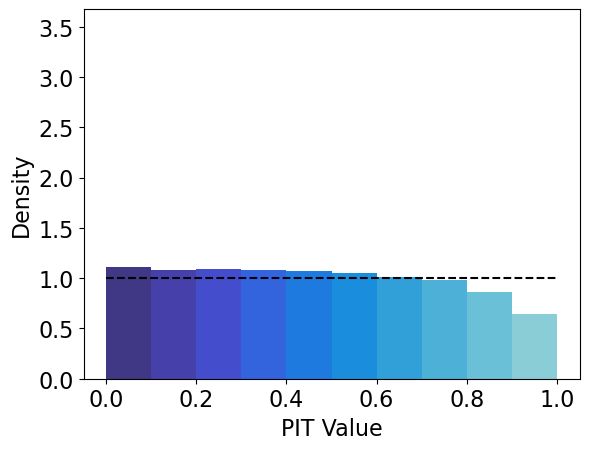

In [65]:
probs = norm.cdf(y.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=10, density=True)

# colors
cm = cmr.get_sub_cmap(cmr.freeze,0.3,0.8)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))


plt.ylim(0,7.35/2)  # Layout
plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.savefig(f"{save_path}/PIT_{name}.pdf", format='pdf', dpi=300, bbox_inches='tight')

## Kolmogorow-Smirnow-Test
The Kolmogorov-Smirnov test is a non-parametric statistical test used to assess whether a sample comes from a specific distribution. It is based on the comparison of the empirical distribution function of the sample with the cumulative distribution function of the hypothesized distribution.
$H_0: F_X=F_0\\
H_1: F_X \neq F_0$

In [10]:
from scipy.stats import kstest, uniform

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(probs, uniform.cdf)

print(p_value)

0.0


## Node Degree vs. Mean CRPS

In [25]:
import networkx as nx

In [26]:
# Get average node Degree
degrees_list = []
for d in tqdm(torch_data_test):
    G = nx.Graph()
    # to cpu for further calculations and plotting
    edge_index = d.edge_index.cpu().numpy()

    # NOTE: edge_index_att holds the Edges of the new graph,
    # however they are labeled consecutively instead of the ordering from stations DataFrame
    station_ids = np.array(d.x[:, 0].cpu())
    edge_index = station_ids[edge_index]  # now the same indexes as in the stations Dataframe are used

    # Add nodes (stations) to the graph
    for i in range(d.num_nodes):
        G.add_node(int(d.x[i,0].cpu()))  # Add Nodes with correct station id
    # Add Edges
    for edge in edge_index.T.tolist():
        if not (G.has_edge(edge[0], edge[1]) or G.has_edge(edge[1], edge[0])):  # Edge only needs to be added once
            G.add_edge(edge[0], edge[1])  # Add Edge

    degrees = G.degree
    degrees_list.append(degrees)

# Create a dictionary to store the sum and count for each ID
id_sum = {}
id_count = {}

# Iterate through the list of dictionaries
for degrees in tqdm(degrees_list):
    # Update the sum and count for the ID
    for id, number in degrees:
        if id in id_sum:
            id_sum[id] += number
            id_count[id] += 1
        else:
            id_sum[id] = number
            id_count[id] = 1

# Calculate the average for each ID
id_to_avg_degree = {}
for id, sum in id_sum.items():
    count = id_count[id]
    id_to_avg_degree[id] = sum / count

# Average CRPS
crps_per_station = crps_no_avg(preds, torch.tensor(y).to(device)).flatten().cpu().numpy()

id_sum_count = {}

# Iterate through the arrays and update the dictionary
for value, id in zip(crps_per_station, ids):
    if id in id_sum_count:
        id_sum_count[id]['sum'] += value
        id_sum_count[id]['count'] += 1
    else:
        id_sum_count[id] = {'sum': value, 'count': 1}

# Calculate the average for each ID
id_to_avg_crps = {}
for id, data in id_sum_count.items():
    id_to_avg_crps[id] = data['sum'] / data['count']

100%|██████████| 365/365 [00:00<00:00, 1887.05it/s]


In [14]:
GraphSAGE_avg_degree= id_to_avg_degree.values()
GraphSAGE_avg_crps = id_to_avg_crps.values()

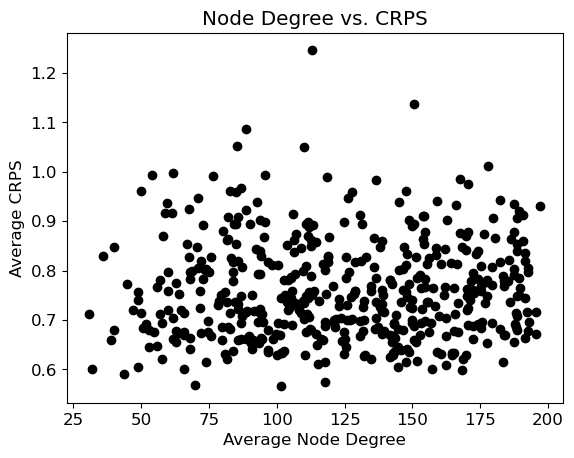

In [35]:
plt.rcParams.update({'font.size': 12})
plt.scatter(id_to_avg_degree.values(), id_to_avg_crps.values(), color="royalblue")
plt.xlabel('Average Node Degree')
plt.ylabel('Average CRPS')
plt.title('Node Degree vs. CRPS')
plt.savefig(f"{save_path}/DegreeCRPS_{name}.pdf", format='pdf', dpi=600, bbox_inches='tight')